# 粘性模型

## indexcoor 类

In [1]:
import numpy as np
from collections import Counter
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

class IndexCoor(list):
    def __init__(self,ls):
        self.extend(ls)

    def __getitem__(self, item):   # 实现切片
        #cls = type(self)    # 相当于cls=Group()  但软编程可维护性好
        if isinstance(item, slice):
            start = item.start
            stop = item.stop
            L = IndexCoor([])
            for x in range(stop):
                if x>=start:
                    L.append(self[x])
            return L
        if isinstance(item,int):
            return list(self)[item]

    def nodeList(self):
        nodelist = {}
        for i in self:
            if i in nodelist:
                nodelist[i][7] +=1
            else:
                nodelist[i]={5:np.linalg.norm(np.array(i)-
                        np.array(self[0])),7:1}
        return nodelist

    def sideView(self):
        h = []
        nodelist = IndexCoor.nodeList(self)
        for k in nodelist:
            h.append(nodelist[k][7])
        a = Counter(h)
        return a 

    def caculateT(self,deltaR):#按照deltaR计算index积分
        nodelist = IndexCoor.nodeList(self)
        w = []
        delta = deltaR
        #delta = radius/2#qqq
        for key in nodelist:
            w.append([nodelist[key][5],nodelist[key][7]])
        w.sort()
        w = np.array(w)
        R = np.arange(0,np.max(w[:,0]),delta)
        RL = np.zeros((len(R),2)) 
        RL[:,0] = R
        for i in range(len(RL)):
            RL[i,1] = np.sum(w[w[:,0]<RL[i,0],1])
            #RL delta*n 列是sum
        return RL
    
    def landCoor(self):# 根据人口index计算土地index
        nodelist = IndexCoor.nodeList(self)
        land = []
        for key,v in nodelist.items():
            land.append(key)
        landindex = IndexCoor(land)
        return landindex
#    def Rx(self,city):
#        Rrhox = caculate(self,city)
#        return Rrhox

    def spatial_range(self):
        nodelist = IndexCoor.nodeList(self)
        x = []
        y = []
        for k in nodelist.keys():
            x.append(k[0])
            y.append(k[1])
        return max(x),min(x),max(y),min(y)

    def paint(self,size = 0.1):
        nodelist = IndexCoor.nodeList(self)
        x = nodelist
        a = []
        c = []
        xmax,xmin,ymax,ymin = IndexCoor.spatial_range(self)
        for k,v in x.items():
            a.append(k)
            c.append(1/(v[7]))
        m = []
        n = []
        for i in a:
            m.append(i[0])
            n.append(i[1])
        plt.figure(figsize=(10,10),dpi=100)
        plt.scatter(m,n,size,c = c)
        plt.xlim((xmin,xmax))
        plt.ylim((ymin,ymax))
        plt.show()
        
    def fun(x, a, n):
        b = 1-x**(-a)
        return 1-np.sign(b)*np.abs(b)**n#numpy 不支持负值的指数
    
    def curveFit(self,deltaR):
        delta = deltaR
        x,y=[],[]
        for a in self.caculate(delta):
            x.append(a[0])
            y.append(a[1])
        popt,pcov = curve_fit(IndexCoor.fun,x,y)
        a = popt[0]
        n = popt[1]
        yvals = IndexCoor.fun(x,a,n)
        plt.plot(x, yvals, 'r',label='polyfit values')
        plt.legend()
        plt.plot(x,y,"b",label = "line")
        return [a,n]

## main 函数

In [2]:
from rtree import index
import numpy as np
import random

def initiate(radius,C,L):
    coordinate = np.ones(2)*L/2.0
    nodelist = {(coordinate[0],coordinate[1]):{5:0.0,7:1}} #5：到心距 7：点数
    index2coor = IndexCoor([(coordinate[0],coordinate[1])])
    #index2coor = [(coordinate[0],coordinate[1])]
    idx = index.Index()
    idx.insert(0,list(np.r_[coordinate,coordinate]))
    limitt = np.r_[coordinate - radius,coordinate + radius] 
    return index2coor,nodelist,idx,limitt

def choosenode(index2coor,nodelist,limitt,C):#?
    white = ( (limitt[2]-limitt[0])*(limitt[3]-limitt[1])-len(nodelist) )*C
    #white = ( (list(limitt)[2]-list(limitt)[0])*(list(limitt)[3]-\
    #list(limitt)[1])-len(nodelist) )*C
    exist = len(index2coor)+len(nodelist)*C
    rnd = random.random()*( exist + white )
    if rnd>exist:
        while 1:
            ii = int( random.random()*(limitt[2]-limitt[0]) + limitt[0] )
            jj = int( random.random()*(limitt[3]-limitt[1]) + limitt[1] )
            if (ii,jj) not in nodelist:
                return (ii,jj),0 # 这个结构如果产生不了输出就会死循环，
            #先随机再判断，贝叶斯问题？？
            #用蒙特卡罗验证落到各个空格子概率相等？
    else:
        pos = random.randint(0,len(index2coor)-1)#左闭右闭
        #随机落到落点顺序上  这很重要
        return index2coor[pos],1

def onestep(index2coor,nodelist,idx,limitt,radius,C,h,L):
    two,flag = choosenode(index2coor,nodelist,limitt,C)  
    i,j = two[0],two[1]
    if flag == 0:
        intersection = list(idx.intersection([i-radius,j-radius,i+radius,j+radius])) 
        if len(intersection) > 0:
            for key in intersection:
                if np.linalg.norm(np.array([index2coor[key]])-np.array([i,j])) <= radius:
                    state = 1
                    break
                else:
                    state = 0
            if state == 1:
                index2coor,nodelist,idx,limitt = \
                insert_newpoint(i,j,nodelist,index2coor,idx,limitt,L,radius)
        return index2coor,nodelist,idx,limitt

    elif flag==1: 
        if getDeltaMax(i,j,nodelist) <= h:
            nodelist[(i,j)][7] += 1
            index2coor.append((i,j))
        else:
            while ((i,j) in nodelist.keys()) and (getDeltaMax(i,j,nodelist) > h ):
            #while getDeltaMax(i,j,nodelist) > h :
                (i,j) = sandpile(i,j,h,nodelist)
            if (i,j) in nodelist.keys():#溢出到有点的格子
                nodelist[(i,j)][7] += 1
                #index2coor[len(index2coor)]=(i,j)
                index2coor.append((i,j))
            else:#溢出到空格子
                index2coor,nodelist,idx,limitt = \
                insert_newpoint(i,j,nodelist,index2coor,idx,limitt,L,radius)
        return index2coor,nodelist,idx,limitt

def insert_newpoint(i,j,nodelist,index2coor,idx,limitt,L,radius):
    nodelist[(i,j)] = {5:np.linalg.norm(np.array([i,j])-L/2),7:1}
    #index2coor[len(index2coor)+1]=(i,j)
    index2coor.append((i,j))
    newpoint = [i,j]
    #这里前往小心，index2coor已经新增了点，所以要减1
    idx.insert( len(index2coor)-1, np.r_[newpoint, newpoint] )  ###idx
    for x in range(2):
        limitt[x]   = round(min(limitt[x],newpoint[x]-radius))
        limitt[x+2] = round(max(limitt[x+2],newpoint[x]+radius))
    return index2coor,nodelist,idx,limitt

def sandpile(i,j,h,nodelist):
    r = i
    c = j
    arounddic = {
	1:(r-1,c-1),2:(r -1,c),3:(r -1,c+1),
	4:(r,c-1),5:(r,c),6:(r,c+1),
	7:(r+1,c-1),8:(r+1,c),9:(r+1,c+1)
	}
    deltas = []
    #邻接阵arov
    arov={}
    fit=[]#满足溢出的位置
    for m in range(1,10):
        if arounddic[m] in nodelist:
            arov[m] = nodelist[arounddic[m]][7]
        else:
            arov[m] = 0
        delta =nodelist[(r,c)][7] - arov[m] 
        if delta == h+1:
            fit.append(m)
    n = len(fit)
    if n == 1:
        pos = fit[0]
    else:
        pos = fit[random.randint(0,n-1)]
    return arounddic[pos]   

def getDeltaMax(i,j,nodelist):
    r = i
    c = j
    arounddic = {
	1:(r-1,c-1),2:(r -1,c),3:(r -1,c+1),
	4:(r,c-1),5:(r,c),6:(r,c+1),
	7:(r+1,c-1),8:(r+1,c),9:(r+1,c+1)
	}
    deltas = []
    arov={}
    for m in range(1,10):
        if arounddic[m] in nodelist:
            arov[m] = nodelist[arounddic[m]][7]
        else:
            arov[m] = 0
        delta =nodelist[(r,c)][7] - arov[m] 
        deltas.append(delta)
    return max(deltas)

## city 类

In [3]:
class city(object):
    def __init__(self,H,C,maxP,radius=10,L=10**5):
        # H 沙堆阈值 C 引力 maxP 最大人口 radius 引力范围 L 背景范围 
        # deltaP 间隔人口 delta 密度采样间隔
        self.C,self.H,self.maxP = C,H,maxP
        self.radius,self.L = radius,L

    def step(self):
        #index2coor,nodelist,idx,limitt = main.initiate(self.radius,self.C,self.L)#初始化
        index2coor,nodelist,idx,limitt = initiate(self.radius,self.C,self.L)
        while len(index2coor) < self.maxP:
            index2coor,nodelist,idx,limitt = onestep\
            (index2coor,nodelist,idx,limitt,self.radius,self.C,self.H,self.L)
        return index2coor    

# 测试

In [4]:
#### 不能用已有的变量名

In [12]:
demo = city(4,0.1,10000)
popindex= demo.step()

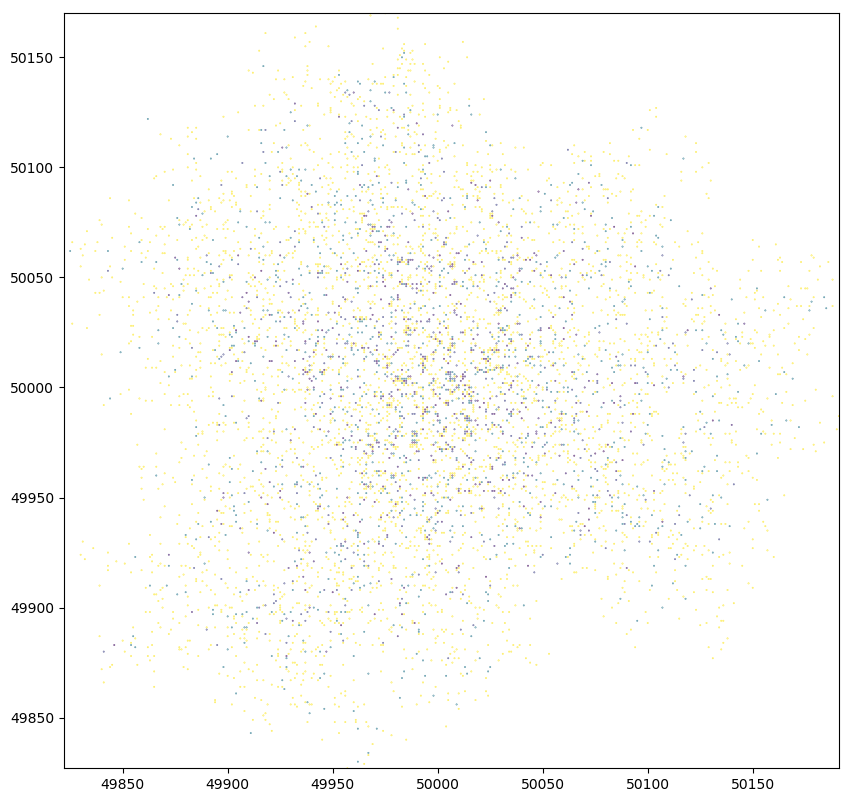

In [13]:
popindex.paint()

In [6]:
popindex.sideView()

Counter({3: 418, 1: 3956, 5: 364, 2: 1077, 4: 198, 6: 4})

In [7]:
popindex.caculateT(10)

array([[   0.,    0.],
       [  10.,  158.],
       [  20.,  698.],
       [  30., 1334.],
       [  40., 2078.],
       [  50., 2859.],
       [  60., 3681.],
       [  70., 4485.],
       [  80., 5242.],
       [  90., 6010.],
       [ 100., 6884.],
       [ 110., 7556.],
       [ 120., 8166.],
       [ 130., 8657.],
       [ 140., 9083.],
       [ 150., 9441.],
       [ 160., 9640.],
       [ 170., 9806.],
       [ 180., 9907.],
       [ 190., 9938.],
       [ 200., 9968.],
       [ 210., 9990.],
       [ 220., 9998.]])

In [8]:
len(popindex.landCoor())

6017

## 人口积分

In [16]:
data = popindex.caculateT(5)

In [11]:
data1= popindex[0:5000].caculateT(5)# 切片

In [ ]:
df = pd.DataFrame(data)
df.to_csv("popdata.csv")# 保存

## 土地积分

In [18]:
landindex = popindex.landCoor()
landdata = landindex.caculateT(5)

In [19]:
landindex2 = popindex[0:5000].landCoor()# 切片
landdata2 = landindex2.caculateT(5)

In [20]:
df = pd.DataFrame(landdata)# landdata
df.to_csv("landdata.csv")# 保存

# 实验